In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
data_df = pd.read_csv("data_files/associations.csv")
data_df.head()

,vVirusNameCorrected,hHostNameFinal,WildDomInReference,DetectionMethod,DetectionQuality,Reference
0,Andes_virus,Abrothrix_longipilis,wild,PCR,2.0,Medina et al. 2009
1,Andes_virus,Abrothrix_olivaceus,wild,Antibodies,0.0,Sosa-Estani et al. 2002
2,Andes_virus,Abrothrix_sanborni,wild,Antibodies,0.0,Padula et al. 2004
3,African_horse_sickness_virus,Acinonyx_jubatus,wild,bcELISA,0.0,Alexander et al. 1995
4,Bluetongue_virus,Acinonyx_jubatus,wild,Antibodies,0.0,Alexander et al. 1994


In [3]:
data_df['DetectionQuality'] = data_df['DetectionQuality'].apply(lambda x: .1 if x == 0 else x)
data_df = data_df.dropna(subset=['DetectionQuality'])

In [4]:
data_df['DetectionQuality'].isnull().value_counts()

False    2804
Name: DetectionQuality, dtype: int64

In [5]:
data_unstack = data_df.groupby(['vVirusNameCorrected',
                                 'hHostNameFinal'])[['DetectionQuality']].sum().unstack().fillna(0)

data_unstack.columns = list(data_unstack.columns.get_level_values(1))
data_unstack.index = list(data_unstack.index.get_level_values(0))

data_unstack.head()

,Abrothrix_longipilis,Abrothrix_olivaceus,Abrothrix_sanborni,Acinonyx_jubatus,Aepyceros_melampus,Aethomys_kaiseri,Aethomys_namaquensis,Akodon_azarae,Akodon_montensis,Akodon_paranaensis,...,Vespertilio_murinus,Vespertilio_sinensis,Vicugna_vicugna,Vulpes_corsac,Vulpes_velox,Vulpes_vulpes,Xerus_erythropus,Xerus_inauris,Zalophus_californianus,Zygodontomys_brevicauda
Adelaide_River_virus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adeno-associated_virus-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adeno-associated_virus-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adeno-associated_virus-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
African_green_monkey_polyomavirus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_virus = data_unstack.dot(data_unstack.T)
df_mammal = data_unstack.T.dot(data_unstack)

In [7]:
B=nx.Graph()

B.add_nodes_from(data_df['vVirusNameCorrected'],bipartite=0)
B.add_nodes_from(data_df['hHostNameFinal'],bipartite=1)

B.add_weighted_edges_from(
    [(row['vVirusNameCorrected'], 
      row['hHostNameFinal'],
      row['DetectionQuality']) for idx, row in data_df.iterrows()])

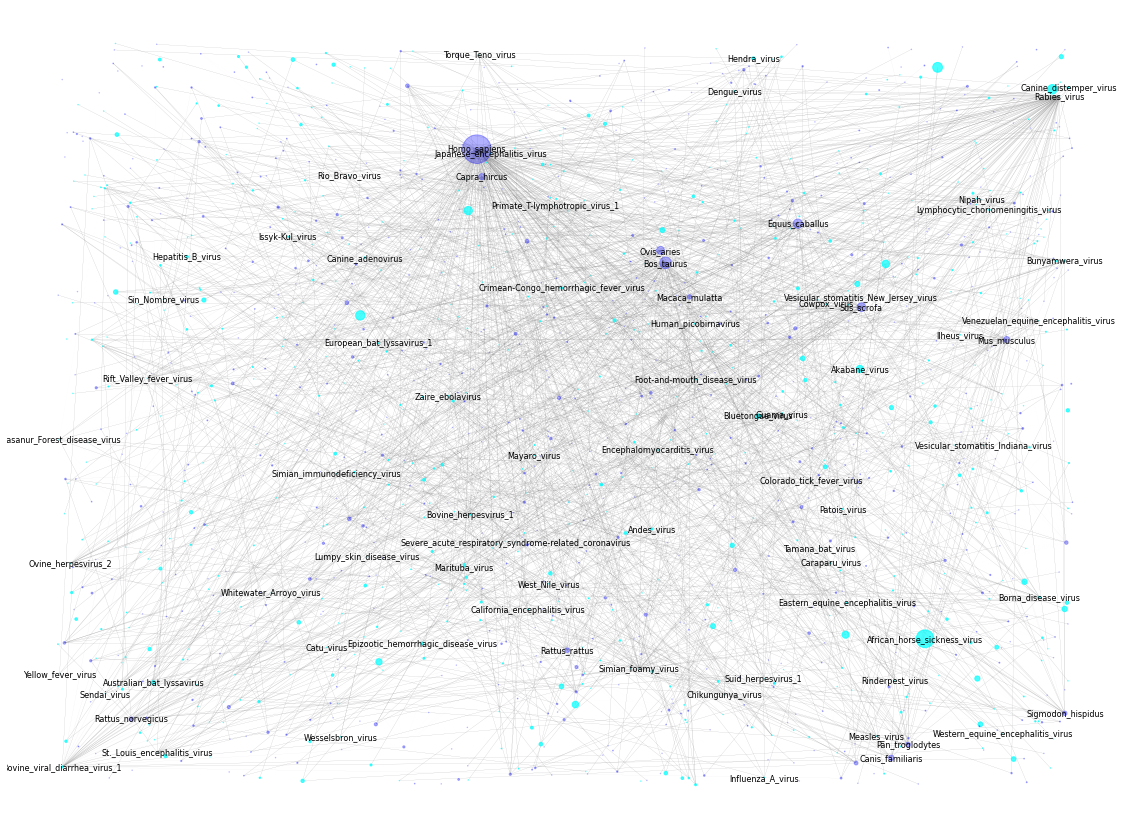

In [8]:
edges = B.edges()
weights = [(B[u][v]['weight']/6)**2 for u,v in edges]
degrees = nx.degree(B)
virus_sizes = [(v/3)**1.5 for k,v in dict(degrees).items() if k in data_unstack.index]
mammal_sizes = [(v/3)**1.5 for k,v in dict(degrees).items() if k in data_unstack.columns]

virus_filter = [k for k,v in dict(degrees).items() if k in data_unstack.index and v > 10]
mammal_filter = [k for k,v in dict(degrees).items() if k in data_unstack.columns and v > 20]

label_pos = {}
pos=nx.random_layout(B)

for key, value in pos.items():
    if key in virus_filter+mammal_filter:
        label_pos[key] = '{}'.format(key)
        
plt.figure(figsize=(20,15))
plt.axis('off')
nx.draw_networkx_nodes(B, 
                       pos, 
                       nodelist=data_unstack.index, 
                       node_color='cyan', 
                       alpha=0.7, 
                       node_size=virus_sizes)
nx.draw_networkx_nodes(B, 
                       pos, 
                       nodelist=data_unstack.columns, 
                       node_color='blue', 
                       alpha=0.3, 
                       node_size=mammal_sizes)

nx.draw_networkx_edges(B, 
                       pos, 
                       edge_color='gray', 
                       width=weights)

nx.draw_networkx_labels(B, 
                        pos, 
                        labels=label_pos,
                        font_size=8,
                        font_weight=10);

In [9]:
nx.write_gml(B, 'B.gml')

![title](data_files/all.png)